# Corner simulation 

In this demonstration, we'll construct a basic Corner situation and simulate the evacuation of agents.

Let's begin by importing the required packages for our simulation:

In [1]:
from shapely import GeometryCollection, Polygon, to_wkt, unary_union
import pathlib
import jupedsim as jps
from jupedsim.distributions import distribute_by_number
import sqlite3  # parse trajectory db
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import Figure
import pedpy # analysis
%matplotlib inline

## Setting up a geometry

 We will be using the a Corner setup as used in the experiments published by [Adrian2018].

In [2]:
complete_area = [
        (5, -2),
        (5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ]
obstacles=[
        # left barrier
        [
            (0,-1),
            (0.25,-1),
            (0.25, 2.75),
            (4.0, 2.75),
            (4.0, 3),
            (0, 3),
        ],
        # right barrier
        [
            (-2.4, -1),
            (-2.4, 5.4),
            (4, 5.4),
            (4, 5.65),
            (-2.65, 5.65),
            (-2.65, -1),
        ],
    ]
walkable_area = pedpy.WalkableArea(complete_area, obstacles)
geometry = jps.geometry_from_shapely(walkable_area._polygon)

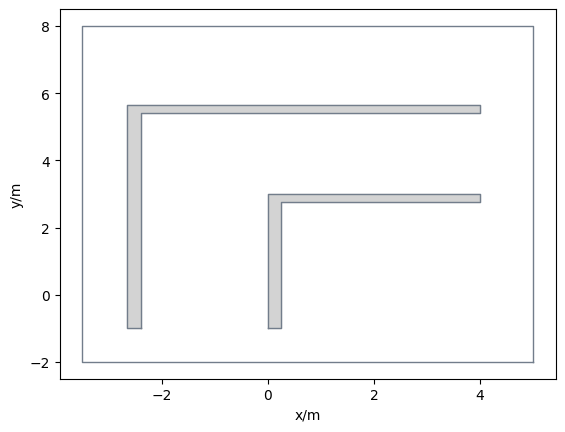

In [3]:
pedpy.plot_walkable_area(walkable_area=walkable_area);

## Operational model
<a id="model"></a>
Once the geometry is set, our subsequent task is to specify the model and its associated parameters.
For this demonstration, we'll employ the "collision-free" model.

In [4]:
profile_id = 1
model_builder = jps.VelocityModelBuilder(a_ped=1.04, d_ped=0.11, a_wall=5, d_wall=0.02)
model_builder.add_parameter_profile(id=profile_id, time_gap=1, tau=0.5, v0=1.2, radius=0.2)
model = model_builder.build()

## Setting Up the Simulation Object

Having established the model and geometry details, and combined with other parameters such as the time step $dt$, we can proceed to construct our simulation object as illustrated below:

In [5]:
dt = 0.01
simulation = jps.Simulation(model=model, geometry=geometry, dt=dt)

## Specifying Routing Details

At this juncture, we'll provide basic routing instructions, guiding the agents to progress towards an exit point.

In [6]:
exit_polygon = [(3.8, 2.9), (4, 2.9), (4, 5.3), (3.8, 5.3)]
exit_id = simulation.add_exit_stage(exit_polygon)
journey = jps.JourneyDescription()
journey.append(exit_id)
journey_id = simulation.add_journey(journey)

## Defining and Distributing Agents

Now, we'll position the agents and establish their attributes, leveraging previously mentioned parameters such as `exit_id` and `profile_id`.

In [7]:
agent_parameters = jps.VelocityModelAgentParameters()
agent_parameters.journey_id = journey_id
agent_parameters.orientation = (1.0, 0.0)
agent_parameters.profile_id = profile_id
total_agents = 10
positions = distribute_by_number(polygon=Polygon([[-0.1, -1],[-0.1, 1.5],[-2.3, 1.5],[-2.3, -1]]),
            number_of_agents=total_agents,
            distance_to_agents=0.4,
            distance_to_polygon=0.4,
            seed=45131502,
        )
for new_pos in positions:  
    agent_parameters.position = new_pos
    simulation.add_agent(agent_parameters)

## Executing the Simulation

With all components in place, we're set to initiate the simulation.
For this demonstration, the trajectories will be recorded in an sqlite database.

In [8]:
trajectory_file = "trajectories.sqlite"
writer = jps.SqliteTrajectoryWriter(pathlib.Path(trajectory_file))
fps=25
rate = 1/dt/fps
writer.begin_writing(fps, to_wkt(GeometryCollection(walkable_area._polygon), rounding_precision=-1))

while simulation.agent_count() > 0:
    if simulation.iteration_count() % rate == 0:
        writer.write_iteration_state(simulation)
    simulation.iterate()
    
        
writer.end_writing()

## Visualizing the Trajectories

For trajectory visualization, we'll extract data from the sqlite database. A straightforward method for this is employing the jupedsim-visualizer.

In [9]:
def sqlite_to_df(trajectory_file: str)->pd.DataFrame:
       """extract dataframe from sqlite.""" 
       with sqlite3.connect(trajectory_file) as conn:
              cursor = conn.cursor()
              cursor.execute(f"SELECT * FROM trajectory_data")
              rows = cursor.fetchall()
              
       return pd.DataFrame(rows,columns=["frame", "id", "x", "y", "ox", "oy"])

def visualize(data_df: pd.DataFrame, area:GeometryCollection) -> Figure:
       """Generate moving trajectories based on simulation"""
       range_color = [0, max(data_df["speed"])]
       data_df["radius"] = 0.2
       fig = px.scatter(
              data_df,
              x="x",
              y="y",
              animation_frame="frame",
              animation_group="id",
              size="radius",
              color="speed",
              range_color=range_color,
              color_continuous_midpoint=np.mean(data_df["speed"]), 
              color_continuous_scale=px.colors.diverging.RdBu_r[::-1],
              labels={"speed": "Speed"},  
       )
       x, y = area.geoms[0].exterior.xy
       fig.add_trace(go.Scatter(x=np.array(x), y=np.array(y),  mode='lines', line={"color": "grey"},))
       for inner in area.geoms[0].interiors:
              xi,yi = zip(*inner.coords[:])
              fig.add_trace(go.Scatter(x=np.array(xi), y=np.array(yi),  mode='lines', line={"color": "grey"},))
       
       minx, miny, maxx, maxy = area.bounds
       fig.update_xaxes(range=[minx, maxx])
       fig.update_yaxes(range=[miny, maxy])
       fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 10
       fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 5
       fig.update_geos(projection_type="equirectangular", visible=True, resolution=110)
       fig.update_traces(marker={"line": {"width": 0.5, "color": "Gray"}})
       fig.update_geos(projection_type="equirectangular", visible=True, resolution=110)
       fig.update_coloraxes(colorbar=dict(title="Speed"))
       fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1), showlegend=False)
       return fig

In [10]:
trajectory_data = pedpy.TrajectoryData(data=sqlite_to_df(trajectory_file), frame_rate=fps)
speed = pedpy.compute_individual_speed(traj_data=trajectory_data, frame_step=5)
speed = speed.merge(trajectory_data.data, on=['id', 'frame'], how='left')

In [11]:
visualize(speed, GeometryCollection(walkable_area._polygon))

## Measurement of the N-T curve and Voronoi density

We evaluate the $N−t$ curve at the bottleneck's exit. The gradient of this curve provides insights into the flow rate through the Corner. Subsequently, we assess the Voronoi density preceding the Corner.

To achieve this, we deifne a measurement line, delineated by two points representing the Corner point. Additionally, we designate a square area to gauge the density directly in front of this entrance.

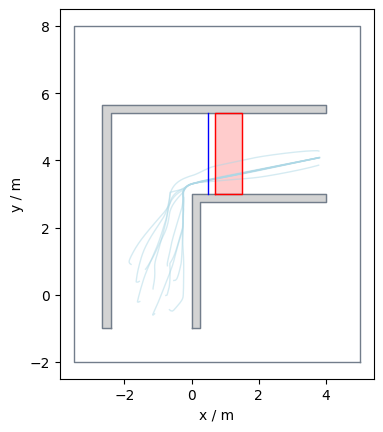

In [12]:
import warnings
warnings.filterwarnings('ignore')
measurement_area = pedpy.MeasurementArea(
    [(0.7, 3), (1.5, 3), (1.5, 5.4), (0.7, 5.4)]
)
measurement_line = pedpy.MeasurementLine([(0.5, 3), (0.5, 5.4)])
nt, crossing_frames = pedpy.compute_n_t(traj_data=trajectory_data, measurement_line= measurement_line,)
pedpy.plot_measurement_setup(
                walkable_area=walkable_area,
                hole_color="lightgrey",
                traj=trajectory_data,
                traj_color="lightblue",
                traj_alpha=0.5,
                traj_width=1,
                measurement_lines=[measurement_line],
                measurement_areas=[measurement_area],
                ml_color="b",
                ma_color="r",
                ma_line_color="r",
                ma_line_width=1,
                ma_alpha=0.2,
            ).set_aspect("equal")

### $N-t$ curve

Evacuation time: 13.16 seconds


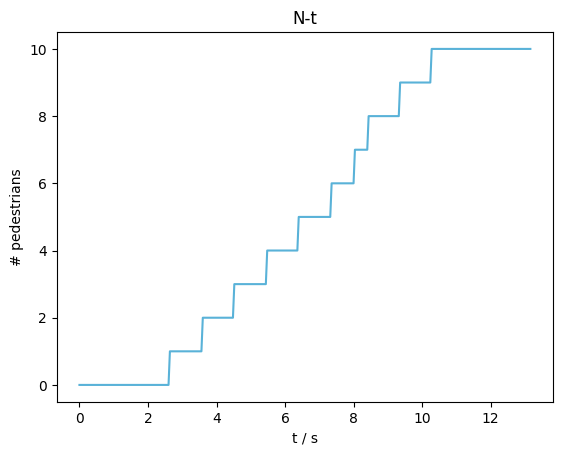

In [13]:
flow_speed = pedpy.compute_flow(
                nt=nt,
                crossing_frames=crossing_frames,
                individual_speed=speed,
                delta_frame=10,
                frame_rate=fps,
            )
pedpy.plot_nt(nt=nt);
print(f"Evacuation time: {max(nt.time)} seconds")

### Voronoi density

In [14]:
individual = pedpy.compute_individual_voronoi_polygons(traj_data=trajectory_data, walkable_area=walkable_area)
density_voronoi, intersecting = pedpy.compute_voronoi_density(individual_voronoi_data=individual, measurement_area=measurement_area)

In [15]:
classic_density = pedpy.compute_classic_density(
    traj_data=trajectory_data, measurement_area=measurement_area
)

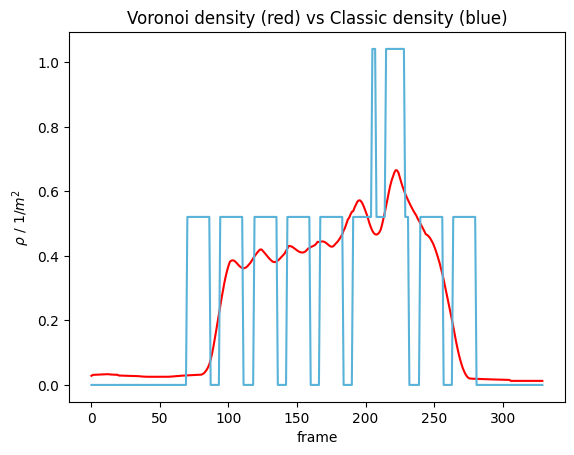

In [16]:
pedpy.plot_density(density=density_voronoi, color="red");
pedpy.plot_density(density=classic_density, title="Voronoi density (red) vs Classic density (blue)");

## References & Further Exploration

The operational model discussed in the Model section is based on the collision-free model. JuPedSim also incorporates another model known as GCFM. For more details on GCFM, refer to another notebook (TODO: Link to the GCFM notebook).

Our demonstration employed a straightforward journey with a singular exit. For a more intricate journey featuring multiple intermediate stops and waiting zones, see the upcoming section (TODO: Link to the advanced journey section).

While we designated a single parameter profile for agents in this example, it's feasible to define multiple parameter profiles. Learn how to alternate between these profiles in the subsequent section (TODO: Link to the profile-switching section).